In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import utils
from d2l import torch as d2l

/home/mikewei/anaconda3/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


ml_data shape: (100000, 4)


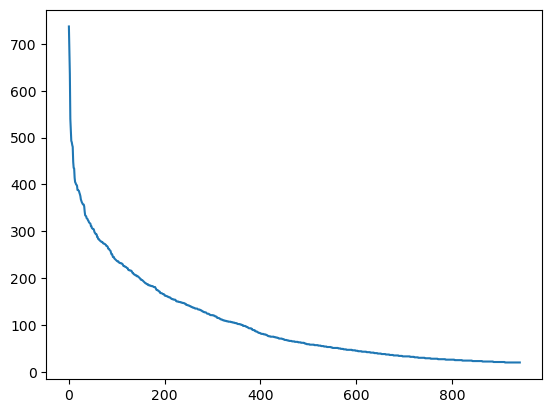

In [2]:
def read_data_ml100k():
    d2l.DATA_HUB['ml-100k'] = (
        'https://files.grouplens.org/datasets/movielens/ml-100k.zip',
        'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')
    ml_data_dir = d2l.download_extract('ml-100k')
    ml_data = pd.read_csv(os.path.join(ml_data_dir, 'u.data'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    print(f'ml_data shape: {ml_data.shape}')
    ml_data_num_users = ml_data.user_id.unique().shape[0]
    ml_data_num_items = ml_data.item_id.unique().shape[0]
    return ml_data, ml_data_num_users, ml_data_num_items

ml_data, ml_data_num_users, ml_data_num_items = read_data_ml100k()
vc = ml_data.user_id.value_counts()
vc.reset_index(drop=True).plot()

def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data


In [3]:
td = split_data_ml100k(ml_data, ml_data_num_users, ml_data_num_items)[0]
uir_tensors = torch.tensor(td.values[:, (0,1,2)])
train_batches = utils.data.DataLoader(utils.data.TensorDataset(uir_tensors[:,0], uir_tensors[:,1], uir_tensors[:,2].float()), batch_size=100, shuffle=True)
u, i, v = next(iter(train_batches))
u, i, v, uir_tensors.shape

(tensor([ 92, 239, 234, 561, 655, 922, 207, 301, 264, 546, 150, 537,  94, 109,
         399, 500, 194, 729, 670, 198, 301, 774, 919, 543, 316, 442, 934, 625,
         279, 725,  56, 896, 287,  98,  56, 285, 892, 730, 699, 135, 472, 692,
         525,  14, 883, 663, 621, 344, 330,  16, 798, 716, 246, 711, 186, 896,
         796, 312, 387, 533, 417, 579, 407, 869, 298, 437, 286, 339,  18, 617,
         894, 592, 616, 654, 561, 314, 561, 334, 536, 288,  83, 158, 251, 314,
         417,  61, 746, 805, 909, 447,   1, 529, 407, 806, 788, 621, 224, 450,
         178, 521]),
 tensor([ 794,  382,  229, 1101, 1144,    1,  177,  233,  200,  145,  291,  197,
          168,  472,  744, 1226,    4,  901,   83,  191,    3,  241,  270,  249,
          633,   39,  488,  300,  203,  288,   67,   95,   39,  163,  408,  455,
            8,  181,  234,  288,   43,  100,  124,  923,  856, 1051, 1228,  183,
          202,   39,  584,  474,  748,  143,  302, 1214,  197,  481,  107,  660,
          411,  328, 

In [9]:
import math
from tqdm import tqdm, trange

hidden_dim = 128

class MF(nn.Module):
    def __init__(self):
        super().__init__()
        self.u_embed = nn.Embedding(1000, hidden_dim)
        self.i_embed = nn.Embedding(2000, hidden_dim)
        self.u_bias = nn.Embedding(1000, 1)
        self.i_bias = nn.Embedding(2000, 1)
        self.loss = nn.MSELoss()
    def forward(self, u, i):
        return (self.u_embed(u) * self.i_embed(i)).sum(axis=1) + self.u_bias(u).squeeze() + self.i_bias(i).squeeze()
    def get_loss(self, u, i, r):
        return self.loss(self(u, i), r)

epoch_num = 5
model = MF()
optim = torch.optim.SGD(model.parameters(), lr=0.001)
for epoch in range(epoch_num):
    loss_val, count = .0, 0
    for u, i, r in train_batches:
        loss = model.get_loss(u, i, r)
        loss_val += loss
        count += 1
        optim.zero_grad()
        loss.backward()
        optim.step()
    loss_val /= count
    rmse = math.sqrt(loss_val)
    print(f'[epoch-{epoch}]  loss-val: {loss_val} rmse: {rmse}')

[epoch-0]  loss-val: 143.1293182373047 rmse: 11.963666588354286
[epoch-1]  loss-val: 139.74778747558594 rmse: 11.821496837354648
[epoch-2]  loss-val: 136.47547912597656 rmse: 11.682272001882877
[epoch-3]  loss-val: 133.41734313964844 rmse: 11.550642542285189
[epoch-4]  loss-val: 130.42970275878906 rmse: 11.420582417669822


In [16]:
from mdl import torch as mdl

class Ml100kData(d2l.DataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        ml_data, ml_data_num_users, ml_data_num_items = self.read_data_ml100k()
        train_data, test_data = self.split_data_ml100k(ml_data, ml_data_num_users, ml_data_num_items)
        self.train_uir= torch.tensor(train_data.values[:, (0,1,2)])
        self.test_uir= torch.tensor(test_data.values[:, (0,1,2)])
    def get_dataloader(self, train):
        if train:
            return self.get_tensorloader((self.train_uir[:,0], self.train_uir[:,1], self.train_uir[:,2].float()), train)
        else:
            return self.get_tensorloader((self.test_uir[:,0], self.test_uir[:,1], self.test_uir[:,2].float()), train)
    def read_data_ml100k(self):
        mdl.DATA_HUB['ml-100k'] = (
            'https://files.grouplens.org/datasets/movielens/ml-100k.zip',
            'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')
        ml_data_dir = mdl.download_extract('ml-100k')
        ml_data = pd.read_csv(os.path.join(ml_data_dir, 'u.data'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
        print(f'ml_data shape: {ml_data.shape}')
        ml_data_num_users = ml_data.user_id.unique().shape[0]
        ml_data_num_items = ml_data.item_id.unique().shape[0]
        return ml_data, ml_data_num_users, ml_data_num_items
    def split_data_ml100k(self, data, num_users, num_items,
                          split_mode='random', test_ratio=0.1):
        """Split the dataset in random mode or seq-aware mode."""
        if split_mode == 'seq-aware':
            train_items, test_items, train_list = {}, {}, []
            for line in data.itertuples():
                u, i, rating, time = line[1], line[2], line[3], line[4]
                train_items.setdefault(u, []).append((u, i, rating, time))
                if u not in test_items or test_items[u][-1] < time:
                    test_items[u] = (i, rating, time)
            for u in range(1, num_users + 1):
                train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
            test_data = [(key, *value) for key, value in test_items.items()]
            train_data = [item for item in train_list if item not in test_data]
            train_data = pd.DataFrame(train_data)
            test_data = pd.DataFrame(test_data)
        else:
            mask = [True if x == 1 else False for x in np.random.uniform(
                0, 1, (len(data))) < 1 - test_ratio]
            neg_mask = [not x for x in mask]
            train_data, test_data = data[mask], data[neg_mask]
        return train_data, test_data

ml100k_data = Ml100kData()

class Regression(d2l.Module):
    def __init__(self, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        l = self.loss(Y_hat, batch[-1])
        self.plot('loss', l, train=False)
        self.plot('rmse', torch.sqrt(l), train=False)
    def loss(self, y_hat, y, averaged=True):
        fn = nn.MSELoss()
        return fn(y_hat, y)


ml_data shape: (100000, 4)


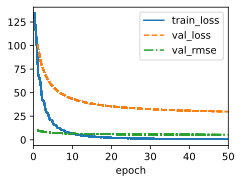

In [17]:
class MatrixFactorization(Regression):
    def __init__(self):
        super().__init__()
        self.hidden_dim = 128
        self.u_embed = nn.Embedding(1000, self.hidden_dim)
        self.i_embed = nn.Embedding(2000, self.hidden_dim)
        self.u_bias = nn.Embedding(1000, 1)
        self.i_bias = nn.Embedding(2000, 1)
    def forward(self, u, i):
        return (self.u_embed(u) * self.i_embed(i)).sum(axis=1) + self.u_bias(u).squeeze() + self.i_bias(i).squeeze()

mf_model = MatrixFactorization()
mdl.Trainer(max_epochs=50, num_gpus=1).fit(mf_model, ml100k_data) 

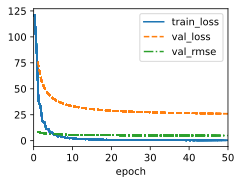

In [21]:
mdl.Trainer(max_epochs=50, num_gpus=1).fit(MatrixFactorization(), Ml100kData(16)) 

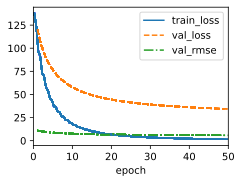

In [20]:
mdl.Trainer(max_epochs=50, num_gpus=1).fit(MatrixFactorization(), Ml100kData(64)) 
